# Loading Data

In [9]:
import numpy as np

def get_data():
    data = np.genfromtxt('data.csv', delimiter=',')
    X = data[:, 0]
    Y = data[:, 1]
    return X, Y

In [10]:
import json

def load(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs, targets

def get_data():
    return load("data.json")

# Neural Network

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(inputs.shape[1] * inputs.shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

In [15]:
inputs, targets = get_data()

model = NeuralNetwork(inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)

train_dataset = TensorDataset(torch.tensor(input_train, dtype=torch.float32), 
                              torch.tensor(target_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(input_test, dtype=torch.float32), 
                             torch.tensor(target_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

history_nn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_nn["loss"].append(train_loss)
    history_nn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    history_nn["val_loss"].append(val_loss)
    history_nn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.1029, Accuracy: 0.3495, Val Loss: 2.0463, Val Accuracy: 0.4035
Epoch 2/50, Loss: 2.0305, Accuracy: 0.4252, Val Loss: 2.0257, Val Accuracy: 0.4319
Epoch 3/50, Loss: 2.0018, Accuracy: 0.4558, Val Loss: 1.9921, Val Accuracy: 0.4640
Epoch 4/50, Loss: 1.9727, Accuracy: 0.4853, Val Loss: 1.9785, Val Accuracy: 0.4796
Epoch 5/50, Loss: 1.9564, Accuracy: 0.5010, Val Loss: 1.9631, Val Accuracy: 0.4963
Epoch 6/50, Loss: 1.9173, Accuracy: 0.5472, Val Loss: 1.9629, Val Accuracy: 0.4970
Epoch 7/50, Loss: 1.8973, Accuracy: 0.5652, Val Loss: 1.9241, Val Accuracy: 0.5324
Epoch 8/50, Loss: 1.8759, Accuracy: 0.5877, Val Loss: 1.9392, Val Accuracy: 0.5224
Epoch 9/50, Loss: 1.8538, Accuracy: 0.6117, Val Loss: 1.9140, Val Accuracy: 0.5461
Epoch 10/50, Loss: 1.8405, Accuracy: 0.6240, Val Loss: 1.9143, Val Accuracy: 0.5474
Epoch 11/50, Loss: 1.8204, Accuracy: 0.6445, Val Loss: 1.9264, Val Accuracy: 0.5330
Epoch 12/50, Loss: 1.8029, Accuracy: 0.6645, Val Loss: 1.8990, Val Accuracy: 0.5634
E

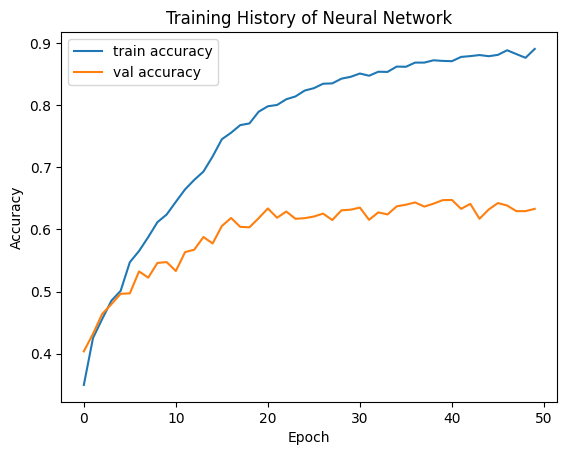

In [16]:
plt.plot(history_nn["accuracy"], label="train accuracy")
plt.plot(history_nn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

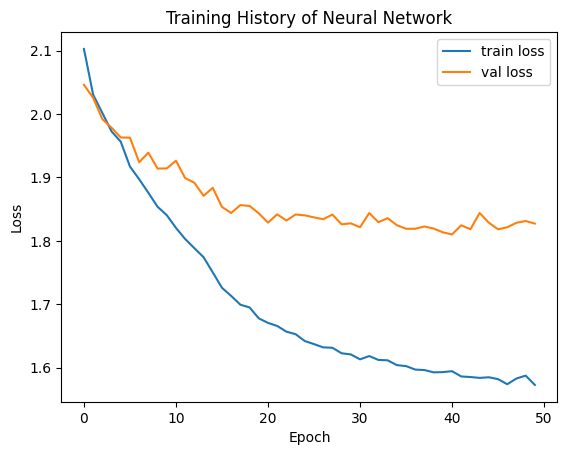

In [17]:
plt.plot(history_nn["loss"], label="train loss")
plt.plot(history_nn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

In [18]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_nn = correct / total
print(f"Test accuracy: {test_accuracy_nn}")

Test accuracy: 0.633177570093458


# Convolutional Neural Network

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 2))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 16, kernel_size=(1, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 1), stride=(2, 2), padding=0)
        self.bn4 = nn.BatchNorm2d(16)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool4(self.relu(self.conv4(x)))
        x = self.bn4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
X, y = get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 50
history_cnn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        inputs = inputs.squeeze(-1)  # Removes the last dimension of size 1

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_cnn["loss"].append(train_loss)
    history_cnn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history_cnn["val_loss"].append(val_loss)
    history_cnn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.0666, Accuracy: 0.2644, Val Loss: 1.7325, Val Accuracy: 0.3692
Epoch 2/50, Loss: 1.6469, Accuracy: 0.4143, Val Loss: 1.4785, Val Accuracy: 0.4526
Epoch 3/50, Loss: 1.4570, Accuracy: 0.4796, Val Loss: 1.3239, Val Accuracy: 0.5307
Epoch 4/50, Loss: 1.3182, Accuracy: 0.5310, Val Loss: 1.2176, Val Accuracy: 0.5821
Epoch 5/50, Loss: 1.2187, Accuracy: 0.5785, Val Loss: 1.1884, Val Accuracy: 0.5874
Epoch 6/50, Loss: 1.1412, Accuracy: 0.6022, Val Loss: 1.0762, Val Accuracy: 0.6188
Epoch 7/50, Loss: 1.0631, Accuracy: 0.6256, Val Loss: 1.0232, Val Accuracy: 0.6482
Epoch 8/50, Loss: 1.0167, Accuracy: 0.6463, Val Loss: 0.9731, Val Accuracy: 0.6642
Epoch 9/50, Loss: 0.9731, Accuracy: 0.6625, Val Loss: 0.9661, Val Accuracy: 0.6662
Epoch 10/50, Loss: 0.9353, Accuracy: 0.6762, Val Loss: 0.9275, Val Accuracy: 0.6923
Epoch 11/50, Loss: 0.8847, Accuracy: 0.6952, Val Loss: 0.8998, Val Accuracy: 0.7049
Epoch 12/50, Loss: 0.8620, Accuracy: 0.7037, Val Loss: 0.9286, Val Accuracy: 0.6749
E

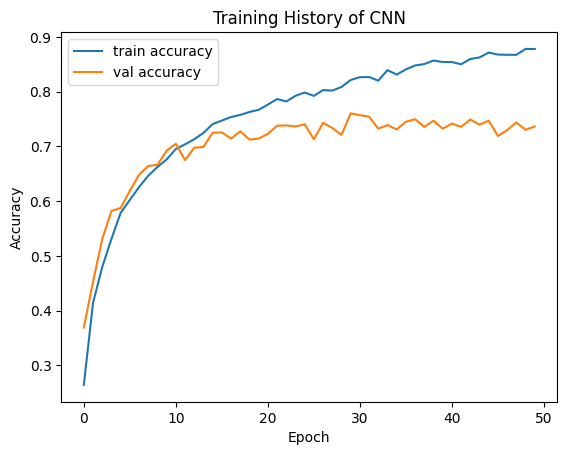

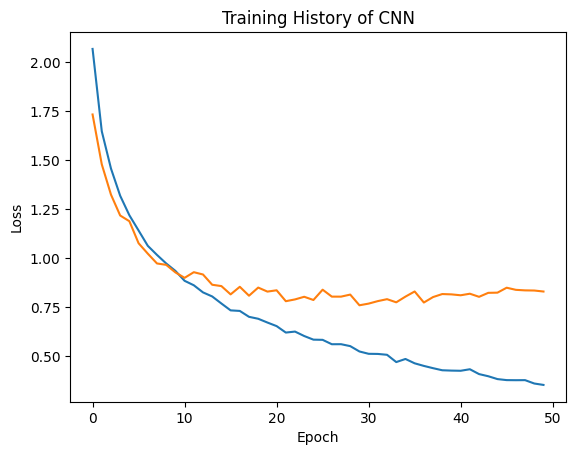

In [21]:
plt.plot(history_cnn["accuracy"], label="train accuracy")
plt.plot(history_cnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend()
plt.show()

plt.plot(history_cnn["loss"], label="train loss")
plt.plot(history_cnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend
plt.show()

In [22]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_cnn = correct / total
print(f"Test accuracy: {test_accuracy_cnn}")

Test accuracy: 0.7553063676411694


# Recurrent Neural Network

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/Users/parsa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
inputs, targets = get_data()

X_train_full, X_test, y_train_full, y_test = train_test_split(inputs, targets, test_size=0.3)

# One-hot encode labels
y_train_full = to_categorical(y_train_full, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Reshape data for RNN input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [14]:
# Build RNN model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for music genres
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train model
model_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

# Evaluate model
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(f"Model Test Loss: {model_loss}")
print(f"Model Test Accuracy: {model_accuracy}")


Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.2550 - loss: 2.0513 - val_accuracy: 0.4850 - val_loss: 1.4567
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.4560 - loss: 1.5401 - val_accuracy: 0.5165 - val_loss: 1.3493
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.4898 - loss: 1.4262 - val_accuracy: 0.5536 - val_loss: 1.2718
Epoch 4/50
 95/175 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5170 - loss: 1.3818

In [ ]:
history_rnn = {"accuracy": model_history.history["accuracy"], "val_accuracy": model_history.history["val_accuracy"],
               "loss": model_history.history["loss"], "val_loss": model_history.history["val_loss"]}

In [ ]:
plt.plot(history_rnn["accuracy"], label="train accuracy")
plt.plot(history_rnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()

plt.plot(history_rnn["loss"], label="train loss")
plt.plot(history_rnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()